# Sentiment Analysis Project

This notebook performs sentiment analysis on text data to classify comments as **positive**, **negative**, or **neutral**.

## Project Overview
- Load and preprocess datasets
- Apply NLP techniques for text cleaning
- Train multiple machine learning models
- Select the best model for deployment
- Provide interactive sentiment prediction

## 1. Import Required Libraries

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("NLTK data downloaded successfully!")

NLTK data downloaded successfully!


## 2. Load and Explore Datasets

In [5]:
# Load datasets with appropriate encoding
train_df = pd.read_csv('dataset/train.csv', encoding='latin-1')
test_df = pd.read_csv('dataset/test.csv', encoding='latin-1')

print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\n" + "="*60)
print("Training Data - First 5 rows:")
print(train_df.head())
print("\n" + "="*60)
print("Training Data Info:")
print(train_df.info())
print("\n" + "="*60)
print("Missing Values in Training Data:")
print(train_df.isnull().sum())
print("\n" + "="*60)
print("Sentiment Distribution:")
print(train_df['sentiment'].value_counts())

Training Data Shape: (27481, 10)
Test Data Shape: (4815, 9)

Training Data - First 5 rows:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -202

## 3. Data Preprocessing - Drop Unnecessary Columns

In [6]:
# Keep only 'text' and 'sentiment' columns for training
# For training data, we only need text and sentiment
train_clean = train_df[['text', 'sentiment']].copy()
test_clean = test_df[['text', 'sentiment']].copy()

# Drop rows with missing values
train_clean = train_clean.dropna()
test_clean = test_clean.dropna()

print("Cleaned Training Data Shape:", train_clean.shape)
print("Cleaned Test Data Shape:", test_clean.shape)
print("\n" + "="*60)
print("Sample cleaned data:")
print(train_clean.head(10))

Cleaned Training Data Shape: (27480, 2)
Cleaned Test Data Shape: (3534, 2)

Sample cleaned data:
                                                text sentiment
0                I`d have responded, if I were going   neutral
1      Sooo SAD I will miss you here in San Diego!!!  negative
2                          my boss is bullying me...  negative
3                     what interview! leave me alone  negative
4   Sons of ****, why couldn`t they put them on t...  negative
5  http://www.dothebouncy.com/smf - some shameles...   neutral
6  2am feedings for the baby are fun when he is a...  positive
7                                         Soooo high   neutral
8                                        Both of you   neutral
9   Journey!? Wow... u just became cooler.  hehe....  positive


## 4. Text Preprocessing

Apply comprehensive text cleaning including:
- Lowercasing
- Removing URLs, mentions, hashtags
- Removing special characters and numbers
- Removing stopwords
- Lemmatization

In [7]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    # Join tokens back to string
    return ' '.join(tokens)

# Apply preprocessing to both datasets
print("Preprocessing training data...")
train_clean['cleaned_text'] = train_clean['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_clean['cleaned_text'] = test_clean['text'].apply(preprocess_text)

print("\nPreprocessing completed!")
print("\n" + "="*60)
print("Example of original vs cleaned text:")
for i in range(3):
    print(f"\nOriginal: {train_clean['text'].iloc[i]}")
    print(f"Cleaned:  {train_clean['cleaned_text'].iloc[i]}")
    print(f"Sentiment: {train_clean['sentiment'].iloc[i]}")
    print("-"*60)

Preprocessing training data...
Preprocessing test data...

Preprocessing completed!

Example of original vs cleaned text:

Original:  I`d have responded, if I were going
Cleaned:  responded going
Sentiment: neutral
------------------------------------------------------------

Original:  Sooo SAD I will miss you here in San Diego!!!
Cleaned:  sooo sad miss san diego
Sentiment: negative
------------------------------------------------------------

Original: my boss is bullying me...
Cleaned:  bos bullying
Sentiment: negative
------------------------------------------------------------
Preprocessing test data...

Preprocessing completed!

Example of original vs cleaned text:

Original:  I`d have responded, if I were going
Cleaned:  responded going
Sentiment: neutral
------------------------------------------------------------

Original:  Sooo SAD I will miss you here in San Diego!!!
Cleaned:  sooo sad miss san diego
Sentiment: negative
-----------------------------------------------------

## 5. Feature Extraction - TF-IDF Vectorization

In [8]:
# Prepare data for modeling
X_train = train_clean['cleaned_text']
y_train = train_clean['sentiment']

X_test = test_clean['cleaned_text']
y_test = test_clean['sentiment']

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform training data
print("Transforming text to TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTraining features shape: {X_train_tfidf.shape}")
print(f"Test features shape: {X_test_tfidf.shape}")
print(f"\nNumber of unique words in vocabulary: {len(tfidf_vectorizer.vocabulary_)}")

Transforming text to TF-IDF features...

Training features shape: (27480, 5000)
Test features shape: (3534, 5000)

Number of unique words in vocabulary: 5000

Training features shape: (27480, 5000)
Test features shape: (3534, 5000)

Number of unique words in vocabulary: 5000


## 6. Model Training and Evaluation

Train multiple machine learning models and compare their performance:
1. Logistic Regression
2. Naive Bayes (Multinomial)
3. Support Vector Machine (SVM)
4. Random Forest Classifier

In [9]:
# Dictionary to store models and their performance
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

print("Training and evaluating models...")
print("="*60)

for name, model in models.items():
    print(f"\n{name}:")
    print("-"*60)
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

print("\n" + "="*60)
print("Model Comparison Summary:")
print("="*60)
for name, result in results.items():
    print(f"{name}: {result['accuracy']:.4f}")

Training and evaluating models...

Logistic Regression:
------------------------------------------------------------
Accuracy: 0.6989

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.62      0.66      1001
     neutral       0.63      0.75      0.69      1430
    positive       0.79      0.71      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.71      0.69      0.70      3534
weighted avg       0.71      0.70      0.70      3534


Naive Bayes:
------------------------------------------------------------
Accuracy: 0.6466

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.52      0.61      1001
     neutral       0.56      0.77      0.65      1430
    positive       0.77      0.59      0.67      1103

    accuracy                           0.65      3534
   macro avg       0.69      0.63      0.64      3534
weighted avg       

## 7. Select Best Model

BEST MODEL: SVM
Accuracy: 0.7117


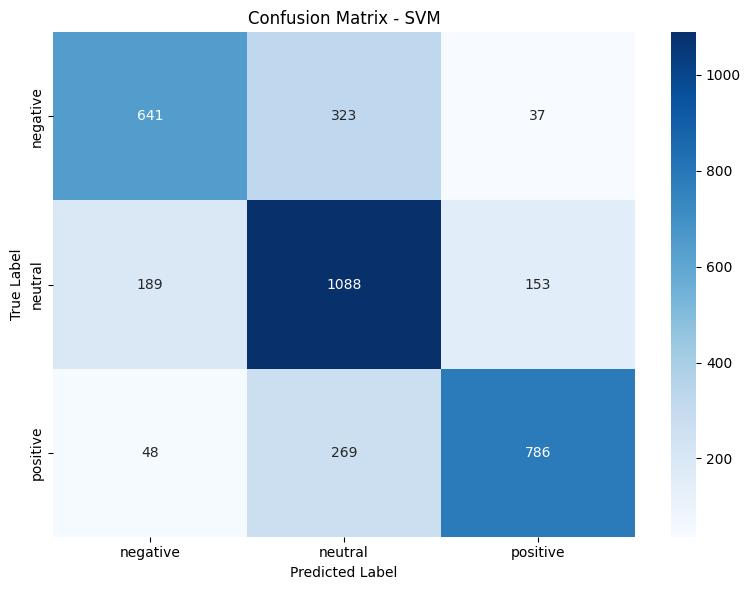


Detailed Classification Report for Best Model:
              precision    recall  f1-score   support

    negative       0.73      0.64      0.68      1001
     neutral       0.65      0.76      0.70      1430
    positive       0.81      0.71      0.76      1103

    accuracy                           0.71      3534
   macro avg       0.73      0.70      0.71      3534
weighted avg       0.72      0.71      0.71      3534



In [10]:
# Select the best model based on accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print("="*60)
print(f"BEST MODEL: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print("="*60)

# Display confusion matrix for best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report for Best Model:")
print(classification_report(y_test, results[best_model_name]['predictions']))

## 8. Create Sentiment Prediction Function

Create a function that takes user input and predicts sentiment

In [11]:
def predict_sentiment(text):
    """
    Predict sentiment of input text
    
    Parameters:
    text (str): Input comment/text to classify
    
    Returns:
    str: Predicted sentiment (positive, negative, or neutral)
    """
    # Preprocess the input text
    cleaned_text = preprocess_text(text)
    
    # Transform to TF-IDF features
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Make prediction using best model
    prediction = best_model.predict(text_tfidf)[0]
    
    # Get prediction probability (if available)
    if hasattr(best_model, 'predict_proba'):
        probabilities = best_model.predict_proba(text_tfidf)[0]
        prob_dict = dict(zip(best_model.classes_, probabilities))
        return prediction, prob_dict
    else:
        return prediction, None

# Test the function with examples
test_comments = [
    "I love this product! It's amazing!",
    "This is terrible. I hate it.",
    "It's okay, nothing special.",
    "Best experience ever! Highly recommended!",
    "Worst purchase I've ever made. Very disappointed."
]

print("="*60)
print("Testing Sentiment Prediction Function")
print("="*60)

for comment in test_comments:
    prediction, probabilities = predict_sentiment(comment)
    print(f"\nComment: {comment}")
    print(f"Predicted Sentiment: {prediction.upper()}")
    if probabilities:
        print("Confidence scores:")
        for sentiment, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"  {sentiment}: {prob:.4f}")
    print("-"*60)

Testing Sentiment Prediction Function

Comment: I love this product! It's amazing!
Predicted Sentiment: POSITIVE
------------------------------------------------------------

Comment: This is terrible. I hate it.
Predicted Sentiment: NEGATIVE
------------------------------------------------------------

Comment: It's okay, nothing special.
Predicted Sentiment: NEUTRAL
------------------------------------------------------------

Comment: Best experience ever! Highly recommended!
Predicted Sentiment: POSITIVE
------------------------------------------------------------

Comment: Worst purchase I've ever made. Very disappointed.
Predicted Sentiment: NEGATIVE
------------------------------------------------------------


## 9. Quick Prediction

Use this cell for quick single predictions without the interactive loop

In [15]:
# Quick prediction - just change the text below
# user_comment = "This is amazing! I absolutely love it!"

user_input = input("\nEnter your comment: ").strip()

prediction, probabilities = predict_sentiment(user_input)

print("="*60)
print("SENTIMENT ANALYSIS RESULT")
print("="*60)
print(f"\nComment: {user_input}")
print(f"\n🎯 Predicted Sentiment: {prediction.upper()}")

if probabilities:
    print("\n📊 Confidence Scores:")
    for sentiment, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        bar_length = int(prob * 30)
        bar = '█' * bar_length
        print(f"  {sentiment:8s}: {bar} {prob:.2%}")

print("="*60)

SENTIMENT ANALYSIS RESULT

Comment: donal trump died

🎯 Predicted Sentiment: NEGATIVE


## 10. Export Model and Vectorizer as Pickle Files

Save the trained model and vectorizer for deployment

In [16]:
import pickle

# Create a directory for models if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the best model
with open('models/sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✓ Model saved: models/sentiment_model.pkl")

# Save the TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✓ Vectorizer saved: models/tfidf_vectorizer.pkl")

# Save the preprocessing function dependencies
preprocessing_data = {
    'lemmatizer': lemmatizer,
    'stop_words': stop_words
}
with open('models/preprocessing_data.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)
print("✓ Preprocessing data saved: models/preprocessing_data.pkl")

print("\n" + "="*60)
print(f"MODEL EXPORT COMPLETE")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print("="*60)
print("\nAll files saved successfully!")
print("You can now use these files in your Flask application.")

✓ Model saved: models/sentiment_model.pkl
✓ Vectorizer saved: models/tfidf_vectorizer.pkl
✓ Preprocessing data saved: models/preprocessing_data.pkl

MODEL EXPORT COMPLETE
Best Model: SVM
Accuracy: 0.7117

All files saved successfully!
You can now use these files in your Flask application.


## 12. Next Steps - Run Flask Web Application

### Files Created:
✓ **app.py** - Flask web application  
✓ **templates/index.html** - Web interface  
✓ **static/style.css** - Styling  
✓ **static/script.js** - Frontend functionality  
✓ **requirements.txt** - Dependencies  
✓ **README.md** - Documentation  

### To Run the Web Application:

1. **First**, run cell 10 above to export the model files

2. **Then**, open a terminal and run:
   ```bash
   python app.py
   ```

3. **Finally**, open your browser and visit:
   ```
   http://localhost:5000
   ```

### Features:
- Beautiful, responsive web interface
- Real-time sentiment analysis
- Confidence scores with visual bars
- Smooth animations and user-friendly design

Enjoy your sentiment analysis web app! 🎉